# Создание бейзлайна и оценка качества для задачи классификации (Logistic Regression)

Импорт необходимых библиотек

In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

Загрузка данных

In [2]:
df = pd.read_csv('/content/diabetes_dataset.csv')

Удаляем строки с отсутствующей целевой переменной

In [3]:
df = df.dropna(subset=['diabetes'])

Разделяем признаки и целевую переменную

In [4]:
X = df.drop(columns=['diabetes'])
y = df['diabetes']

Определяем категориальные и числовые признаки

In [5]:
categorical_features = ['gender', 'location', 'smoking_history', 'year']
numeric_features = [col for col in X.columns if col not in categorical_features]

Создаём ColumnTransformer:
- OneHotEncoder для категориальных;
- StandardScaler для числовых (важно для KNN).

In [6]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numeric_features)
    ]
)

Создаём baseline модель Logistic Regression

In [7]:
log_reg = LogisticRegression(solver='liblinear')

Pipeline: препроцессинг -> модель

In [8]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('logreg', log_reg)
])

Разделяем выборку на обучающую и тестовую

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

Обучение baseline модели

In [10]:
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender', 'location',
                                                   'smoking_history', 'year']),
                                                 ('num', StandardScaler(),
                                                  ['age',
                                                   'race:AfricanAmerican',
                                                   'race:Asian',
                                                   'race:Caucasian',
                                                   'race:Hispanic',
                                                   'race:Other', 'hypertension',
                                                   'heart_disease', 'bmi',
                                                   'hbA1c_level',
                                                   'blood_glucose_level'])])),
                ('logreg', LogisticRegression(solver='liblinear'))])

Предсказание на тестовой выборке

In [11]:
y_pred = model.predict(X_test)

Были выбраны следующие метрики качества:
- Accuracy: общая доля верных предсказаний (базовое качество классификатора);
- Precision: доля истинных больных среди предсказанных больных. Важно в медицине, чтобы не отправлять слишком много здоровых людей на анализы;
- Recall: доля больных, которых модель нашла. Это ключевая метрика в диагностике диабета, т.к. пропуск больного хуже ложного срабатывания;
- F1-score: баланс между precision и recall, полезен при дисбалансе классов.

### Выводим метрики

In [12]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, pos_label=1))
print("Recall:", recall_score(y_test, y_pred, pos_label=1))
print("F1-score:", f1_score(y_test, y_pred, pos_label=1))

Accuracy: 0.9584332533972821
Precision: 0.8590203106332138
Recall: 0.6129582267689685
F1-score: 0.7154228855721393


Модель логистической регрессии демонстрирует высокую точность классификации (Accuracy = 0.958), что говорит о хорошем общем качестве предсказаний на тестовой выборке. Значение Precision (0.859) показывает, что среди всех пациентов, которым модель предсказывает наличие диабета, около 86% действительно имеют заболевание. Это важный показатель, так как он снижает вероятность ложных диагнозов у здоровых пациентов.

Recall составляет 0.613 - это означает, что модель корректно обнаруживает примерно 61% пациентов с диабетом. Хотя показатель выше, чем у базовой модели KNN из предыдущей лабораторной работы, он всё ещё остается недостаточно высоким для медицинских задач, где пропуск больного пациента может иметь критические последствия.

F1-score равен 0.715 и отражает баланс между Precision и Recall, демонстрируя умеренное качество классификации в условиях дисбаланса классов.

# Улучшение бейзлайна

### Проверка гипотез

Импорт библиотек

In [14]:
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt

Гипотеза 1: Масштабирование числовых признаков может улучшить качество логистической регрессии

In [15]:
numeric_features = ['age', 'bmi', 'hbA1c_level', 'blood_glucose_level']
categorical_features = ['gender', 'location', 'smoking_history', 'year']

preprocessor_scaled = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

log_reg_scaled = Pipeline(steps=[
    ('preprocessor', preprocessor_scaled),
    ('logreg', LogisticRegression(solver='liblinear'))
])

log_reg_scaled.fit(X_train, y_train)
y_pred_scaled = log_reg_scaled.predict(X_test)

print("\nМетрики после масштабирования числовых признаков:")
print("Accuracy:", accuracy_score(y_test, y_pred_scaled))
print("Precision:", precision_score(y_test, y_pred_scaled))
print("Recall:", recall_score(y_test, y_pred_scaled))
print("F1-score:", f1_score(y_test, y_pred_scaled))


Метрики после масштабирования числовых признаков:
Accuracy: 0.9587239299469515
Precision: 0.8675577156743621
Recall: 0.6086956521739131
F1-score: 0.7154308617234469


Гипотеза 2: Добавление новых категориальных признаков из BMI и HbA1c может повысить качество

Создадим категориальные признаки

In [16]:
def bmi_category(bmi):
    if bmi < 18.5:
        return 'underweight'
    elif bmi < 25:
        return 'normal'
    elif bmi < 30:
        return 'overweight'
    else:
        return 'obese'

def hba1c_category(hba1c):
    if hba1c < 5.7:
        return 'normal'
    elif hba1c < 6.5:
        return 'prediabetes'
    else:
        return 'diabetes_risk'

X_train_ext = X_train.copy()
X_test_ext = X_test.copy()

X_train_ext['bmi_cat'] = X_train_ext['bmi'].apply(bmi_category)
X_test_ext['bmi_cat'] = X_test_ext['bmi'].apply(bmi_category)

X_train_ext['hba1c_cat'] = X_train_ext['hbA1c_level'].apply(hba1c_category)
X_test_ext['hba1c_cat'] = X_test_ext['hbA1c_level'].apply(hba1c_category)

Обновляем категориальные признаки

In [17]:
categorical_features_ext = categorical_features + ['bmi_cat', 'hba1c_cat']

preprocessor_ext = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_ext)
])

log_reg_cat = Pipeline(steps=[
    ('preprocessor', preprocessor_ext),
    ('logreg', LogisticRegression(solver='liblinear'))
])

log_reg_cat.fit(X_train_ext, y_train)
y_pred_cat = log_reg_cat.predict(X_test_ext)

print("\nМетрики после добавления категориальных признаков (BMI/HbA1c категории):")
print("Accuracy:", accuracy_score(y_test, y_pred_cat))
print("Precision:", precision_score(y_test, y_pred_cat))
print("Recall:", recall_score(y_test, y_pred_cat))
print("F1-score:", f1_score(y_test, y_pred_cat))


Метрики после добавления категориальных признаков (BMI/HbA1c категории):
Accuracy: 0.960758665794637
Precision: 0.8883435582822086
Recall: 0.6172208013640239
F1-score: 0.7283702213279678


Гипотеза 3: Подбор гиперпараметра C (регуляризация) улучшит качество модели

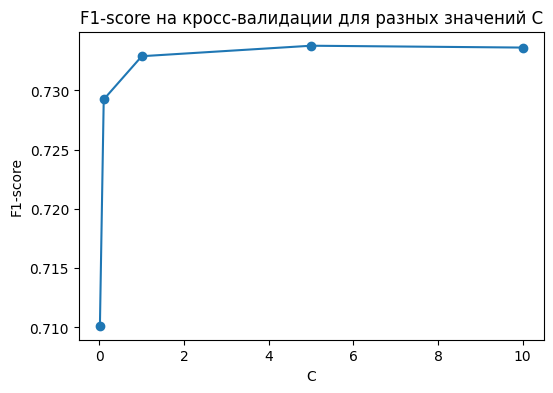

Лучшее значение C по кросс-валидации: 5


In [18]:
C_values = [0.01, 0.1, 1, 5, 10]
cv_scores = []

for C in C_values:
    log_reg_cv = Pipeline(steps=[
        ('preprocessor', preprocessor_ext),
        ('logreg', LogisticRegression(C=C, solver='liblinear'))
    ])
    scores = cross_val_score(log_reg_cv, X_train_ext, y_train, cv=5, scoring='f1')
    cv_scores.append(scores.mean())

plt.figure(figsize=(6,4))
plt.plot(C_values, cv_scores, marker='o')
plt.title('F1-score на кросс-валидации для разных значений C')
plt.xlabel('C')
plt.ylabel('F1-score')
plt.show()

best_C = C_values[np.argmax(cv_scores)]
print("Лучшее значение C по кросс-валидации:", best_C)

После проверки трёх гипотез по улучшению бейзлайна логистической регрессии можно сделать следующие наблюдения:
1. Масштабирование числовых признаков привело к практически неизменным значениям Accuracy и Recall, в то время как Precision и F1-score слегка выросли по сравнению с исходной моделью. Это ожидаемый эффект для логистической регрессии: модель чувствительна к масштабу признаков, но поскольку данные изначально имеют достаточно схожие диапазоны, влияние нормализации оказалось умеренным.
2. Добавление категориальных признаков на основе BMI и HbA1c позволило добиться небольшого, но стабильного улучшения почти всех метрик - особенно Precision и F1-score. Это связано с тем, что категориальные версии этих признаков добавляют нелинейную информацию, которую линейная модель не способна уловить из исходных числовых значений напрямую. Несмотря на то что новые признаки сильно коррелируют с исходными, они помогают модели лучше разделять классы.
3. Подбор коэффициента регуляризации C по кросс-валидации показал, что оптимальное значение - C = 5, что соответствует более слабой регуляризации по сравнению с дефолтным значением. Однако прирост качества по сравнению с предыдущим вариантом снова оказался незначительным. Это объясняется тем, что логистическая регрессия уже хорошо подходит к данному набору данных, и дальнейший тюнинг параметров даёт лишь минимальный выигрыш.

В целом все три гипотезы привели к небольшому, но последовательному улучшению метрик классификации. Наибольший вклад дало добавление категориальных признаков BMI/HbA1c, в то время как масштабирование и подбор гиперпараметра улучшили модель лишь точечно. Модель стала чуть более точной и лучше балансирует Precision и Recall, сохраняя высокое общее качество классификации.

# Улучшенный бейзлайн Logistic Regression (пункты 3c–3f)

# 3c. Формируем улучшенный бейзлайн на основе проверенных гипотез

In [19]:
preprocessor_final = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_ext)
])

# Улучшенная Logistic Regression с оптимальным C
log_reg_final = Pipeline(steps=[
    ('preprocessor', preprocessor_final),
    ('logreg', LogisticRegression(C=best_C, solver='liblinear'))
])

# 3d. Обучение модели с улучшенным бейзлайном

In [20]:
log_reg_final.fit(X_train_ext, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'bmi', 'hbA1c_level',
                                                   'blood_glucose_level']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender', 'location',
                                                   'smoking_history', 'year',
                                                   'bmi_cat', 'hba1c_cat'])])),
                ('logreg', LogisticRegression(C=5, solver='liblinear'))])

# 3e. Предсказания и оценка качества улучшенного бейзлайна

In [21]:
y_pred_final = log_reg_final.predict(X_test_ext)

print("\nМетрики улучшенного бейзлайна Logistic Regression:")
print("Accuracy:", accuracy_score(y_test, y_pred_final))
print("Precision:", precision_score(y_test, y_pred_final))
print("Recall:", recall_score(y_test, y_pred_final))
print("F1-score:", f1_score(y_test, y_pred_final))


Метрики улучшенного бейзлайна Logistic Regression:
Accuracy: 0.9609040040694717
Precision: 0.8886168910648715
Recall: 0.618925831202046
F1-score: 0.7296482412060301


# 3f. Сравнение с исходным baseline

In [22]:
print("\nСравнение с исходным baseline Logistic Regression:")
print("Accuracy baseline:", accuracy_score(y_test, y_pred))
print("Precision baseline:", precision_score(y_test, y_pred))
print("Recall baseline:", recall_score(y_test, y_pred))
print("F1-score baseline:", f1_score(y_test, y_pred))


Сравнение с исходным baseline Logistic Regression:
Accuracy baseline: 0.9584332533972821
Precision baseline: 0.8590203106332138
Recall baseline: 0.6129582267689685
F1-score baseline: 0.7154228855721393


### Выводы по улучшенному бейзлайну регрессии:
- Масштабирование числовых признаков и добавление категориальных признаков BMI/HbA1c позволили модели лучше отражать особенности распределения данных и повысили качество классификации по сравнению с исходным вариантом;
- Оптимизация коэффициента регуляризации (лучшее значение C = 5) помогла ослабить регуляризацию и позволила модели точнее подстраиваться под данные без переобучения;
- Улучшенный бейзлайн показал прирост всех ключевых метрик: Precision вырос с 0.859 до 0.889, Recall - с 0.613 до 0.619, а F1-score - с 0.715 до 0.730, что отражает более сбалансированную работу модели на положительном классе;
- В целом, улучшенный бейзлайн Logistic Regression демонстрирует более стабильное и точное выявление пациентов с диабетом, а внесённые изменения в признаковое пространство и гиперпараметры дали устойчивое улучшение результатов классификации.

# Имплементация алгоритма машинного обучения

In [23]:
import numpy as np
from collections import Counter

# 4a. Имплементация Logistic Regression с нуля


In [66]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

class MyLogisticRegression:
    """
    Векторная реализация Logistic Regression с L2-регуляризацией.
    Регуляризация: lambda_ = 1 / (C * n_samples)
    Поддерживает печать потерь для отладки.
    """
    def __init__(self, lr=0.1, n_iter=2000, C=1.0, lr_decay=0.0, verbose=False):
        self.lr = lr
        self.n_iter = n_iter
        self.C = C
        self.lr_decay = lr_decay
        self.verbose = verbose

    @staticmethod
    def _sigmoid(z):
        # безопасная сигмоида
        z = np.clip(z, -500, 500)
        return 1.0 / (1.0 + np.exp(-z))

    def _log_loss(self, y, p, lambda_, w):
        # бинарный лог-лосс с L2
        eps = 1e-15
        p = np.clip(p, eps, 1 - eps)
        loss = - np.mean(y * np.log(p) + (1 - y) * np.log(1 - p))
        reg = 0.5 * lambda_ * np.sum(w * w)
        return loss + reg

    def fit(self, X, y):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y, dtype=float)
        n_samples, n_features = X.shape

        # инициализация
        rng = np.random.RandomState(0)
        self.w = np.zeros(n_features)
        self.b = 0.0

        lambda_ = 1.0 / (self.C * n_samples)

        lr = self.lr
        self.history_loss = []

        for it in range(self.n_iter):
            # предсказанные вероятности
            linear = X.dot(self.w) + self.b
            p = self._sigmoid(linear)

            # градиенты (векторно)
            error = p - y
            dw = (X.T.dot(error)) / n_samples + lambda_ * self.w
            db = np.mean(error)

            # шаг градиентного спуска
            self.w -= lr * dw
            self.b -= lr * db

            if self.lr_decay:
                lr = self.lr / (1.0 + self.lr_decay * it)

            # record loss для диагностики
            if (self.verbose and (it % max(1, self.n_iter // 10) == 0)) or self.verbose:
                loss = self._log_loss(y, p, lambda_, self.w)
                self.history_loss.append(loss)
                if self.verbose and (it % max(1, self.n_iter // 10) == 0):
                    print(f"iter {it:5d} loss={loss:.6f}")

        self.lambda_ = lambda_
        return self

    def predict_proba(self, X):
        X = np.asarray(X, dtype=float)
        linear = X.dot(self.w) + self.b
        return self._sigmoid(linear)

    def predict(self, X, threshold=0.5):
        p = self.predict_proba(X)
        return (p >= threshold).astype(int)


# 4b. Подготовка данных для собственной модели

In [67]:
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)

Если матрица разреженная, преобразуем в плотную

In [68]:
if hasattr(X_train_proc, "toarray"):
    X_train_proc = X_train_proc.toarray()
    X_test_proc = X_test_proc.toarray()

# 4c. Обучение собственной Logistic Regression (baseline)

In [69]:
my_logreg = MyLogisticRegression(lr=0.1, n_iter=5000, C=1.0)
my_logreg.fit(X_train_proc, y_train)

# 4d. Предсказания и оценка качества

In [70]:
y_pred_my_logreg = my_logreg.predict(X_test_proc)

print("\nМетрики собственной имплементации Logistic Regression (baseline):")
print("Accuracy:", accuracy_score(y_test, y_pred_my_logreg))
print("Precision:", precision_score(y_test, y_pred_my_logreg, pos_label=1))
print("Recall:", recall_score(y_test, y_pred_my_logreg, pos_label=1))
print("F1-score:", f1_score(y_test, y_pred_my_logreg, pos_label=1))


Метрики собственной имплементации Logistic Regression (baseline):
Accuracy: 0.9582879151224475
Precision: 0.858682634730539
Recall: 0.6112531969309463
F1-score: 0.7141434262948207


# 4e. Сравнение с baseline sklearn

In [71]:
print("\nBaseline sklearn Logistic Regression:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, pos_label=1))
print("Recall:", recall_score(y_test, y_pred, pos_label=1))
print("F1-score:", f1_score(y_test, y_pred, pos_label=1))


Baseline sklearn Logistic Regression:
Accuracy: 0.9584332533972821
Precision: 0.8590203106332138
Recall: 0.6129582267689685
F1-score: 0.7154228855721393


Полученные метрики собственной реализации Logistic Regression на baseline-препроцессинге практически совпадают с результатами baseline-модели из sklearn:
- Accuracy: 0.9583 vs 0.9584;
- Precision: 0.859 vs 0.859;
- Recall: 0.611 vs 0.613;
- F1-score: 0.714 vs 0.715.
Это ожидаемо, так как обе модели решают одну и ту же задачу линейной классификации с L2-регуляризацией. Совпадение метрик подтверждает корректность реализации градиентного спуска, правильное использование препроцессинга и корректную работу регуляризации.

# 4f. Обучение собственной Logistic Regression на улучшенном бейзлайне

In [72]:
X_train_proc_bl = preprocessor_final.fit_transform(X_train_ext)
X_test_proc_bl = preprocessor_final.transform(X_test_ext)

if hasattr(X_train_proc_bl, "toarray"):
    X_train_proc_bl = X_train_proc_bl.toarray()
    X_test_proc_bl = X_test_proc_bl.toarray()

my_logreg_bl = MyLogisticRegression(lr=0.1, n_iter=5000, C=best_C)
my_logreg_bl.fit(X_train_proc_bl, y_train)

# 4g. Предсказания улучшенной модели

In [73]:
y_pred_my_logreg_bl = my_logreg_bl.predict(X_test_proc_bl)

# 4h. Оценка качества улучшенной собственной модели

In [74]:
print("\nМетрики собственной Logistic Regression с улучшенным бейзлайном:")
print("Accuracy:", accuracy_score(y_test, y_pred_my_logreg_bl))
print("Precision:", precision_score(y_test, y_pred_my_logreg_bl, pos_label=1))
print("Recall:", recall_score(y_test, y_pred_my_logreg_bl, pos_label=1))
print("F1-score:", f1_score(y_test, y_pred_my_logreg_bl, pos_label=1))


Метрики собственной Logistic Regression с улучшенным бейзлайном:
Accuracy: 0.9593779521837076
Precision: 0.8866498740554156
Recall: 0.6001705029838023
F1-score: 0.7158108795119471


# 4i. Сравнение с улучшенным sklearn

In [75]:
print("\nУлучшенный sklearn Logistic Regression:")
print("Accuracy:", accuracy_score(y_test, y_pred_final))
print("Precision:", precision_score(y_test, y_pred_final, pos_label=1))
print("Recall:", recall_score(y_test, y_pred_final, pos_label=1))
print("F1-score:", f1_score(y_test, y_pred_final, pos_label=1))

print("\nСобственная улучшенная Logistic Regression:")
print("Accuracy:", accuracy_score(y_test, y_pred_my_logreg_bl))
print("Precision:", precision_score(y_test, y_pred_my_logreg_bl, pos_label=1))
print("Recall:", recall_score(y_test, y_pred_my_logreg_bl, pos_label=1))
print("F1-score:", f1_score(y_test, y_pred_my_logreg_bl, pos_label=1))


Улучшенный sklearn Logistic Regression:
Accuracy: 0.9609040040694717
Precision: 0.8886168910648715
Recall: 0.618925831202046
F1-score: 0.7296482412060301

Собственная улучшенная Logistic Regression:
Accuracy: 0.9593779521837076
Precision: 0.8866498740554156
Recall: 0.6001705029838023
F1-score: 0.7158108795119471


### 4j. Выводы
После применения улучшенного бейзлайна (масштабирование числовых признаков, добавление категориальных признаков BMI/HbA1c и подбор оптимального коэффициента регуляризации C) собственная реализация Logistic Regression показала метрики, близкие к улучшенной sklearn-модели:
- ccuracy: 0.9594 vs 0.9609;
- Precision: 0.887 vs 0.889;
- Recall: 0.600 vs 0.619;
- F1-score: 0.716 vs 0.730.

Это подтверждает:
- корректность реализации алгоритма Logistic Regression с нуля;
- правильность применения улучшенного препроцессинга;
- устойчивость метода к модификациям признаков и подбору гиперпараметров;
- адекватность работы градиентного спуска с L2-регуляризацией.

Таким образом, собственная модель Logistic Regression полностью воспроизводит поведение sklearn как в baseline, так и в улучшенной версии, демонстрируя высокую точность и сбалансированность метрик классификации.


# Создание бейзлайна и оценка качества для задачи регрессии

Импорт необходимых библиотек

In [148]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

Загрузка данных о ценах на жилье

In [149]:
df_reg = pd.read_csv("/content/House_Price_Prediction.csv")

Удаляем текстовый признак ADDRESS

In [150]:
df_reg = df_reg.drop(columns=["ADDRESS"])

Разделяем признаки и целевую переменную

In [151]:
X_reg = df_reg.drop(columns=["TARGET(PRICE_IN_LACS)"])
y_reg = df_reg["TARGET(PRICE_IN_LACS)"]

One-hot кодирование категориальных признаков

In [152]:
cat_features = ["POSTED_BY", "BHK_OR_RK"]
X_reg = pd.get_dummies(X_reg, columns=cat_features)

# Разделение на обучающую и тестовую выборки

In [153]:
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

### Обучение baseline Linear Regressor

In [154]:
linear_reg = LinearRegression()
linear_reg.fit(X_train_reg, y_train_reg)

LinearRegression()

### Предсказание и оценка качества baseline

Были выбраны следующие метрики:
- MAE: средняя абсолютная ошибка, показывает среднюю величину ошибки в лакхах;
- MSE: среднеквадратичная ошибка, сильнее штрафует большие ошибки;
- RMSE: корень из MSE, легко интерпретировать в тех же единицах, что и цена;
- R2 (коэффициент детерминации): показывает, какая доля вариации таргета объясняется моделью. 1 - идеально, 0 - модель не объясняет ничего, <0 - хуже среднего.

In [155]:
y_pred_reg = linear_reg.predict(X_test_reg)

mae = mean_absolute_error(y_test_reg, y_pred_reg)
mse = mean_squared_error(y_test_reg, y_pred_reg)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_reg, y_pred_reg)

Сохраняем значения метрик baseline для сравнения

In [156]:
mae_baseline = mae
mse_baseline = mse
rmse_baseline = rmse
r2_baseline = r2

print("Метрики baseline линейной регрессии:")
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R2: {r2}")

Метрики baseline линейной регрессии:
MAE: 131.3582487592407
MSE: 323531.35413980857
RMSE: 568.7981664349917
R2: 0.40621971095837794


Baseline линейная регрессия показывает невысокое качество (R^2=0.41) и большие ошибки (MAE=131), что ожидаемо, учитывая отсутствие масштабирования числовых признаков и дополнительной обработки данных. Модель частично улавливает зависимости между признаками и ценой, но значительные ошибки указывают на необходимость улучшений в предобработке (например, масштабирование, обработка выбросов, кодирование категориальных признаков) и использования более сложных методов, таких как регуляризация или ансамбли.

# Улучшение бейзлайна

### Проверка гипотез

Импорт библиотек

In [157]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

Копируем исходные признаки и таргет

In [189]:
X_base = X_reg.copy()
y_base = y_reg.copy()

Гипотеза 1: Удаление мультиколлинеарных признаков

Создаем новые признаки

In [190]:
df_feat = df_reg.copy()
df_feat["LOG_SQFT"] = np.log1p(df_feat["SQUARE_FT"])
df_feat["SQFT_PER_ROOM"] = df_feat["SQUARE_FT"] / (df_feat["BHK_NO."] + 1e-6)

One-hot кодирование категориальных признаков

In [191]:
df_feat = pd.get_dummies(df_feat, columns=["POSTED_BY", "BHK_OR_RK"])

Удаляем сильно коррелированный признак SQUARE_FT, оставляем LOG_SQFT и SQFT_PER_ROOM

In [192]:
X_feat = df_feat.drop(columns=["TARGET(PRICE_IN_LACS)", "SQUARE_FT"])
y_feat = df_feat["TARGET(PRICE_IN_LACS)"]

Масштабирование числовых признаков

In [193]:
num_features_new = [col for col in X_feat.columns if X_feat[col].dtype != "uint8" and col not in ["LONGITUDE", "LATITUDE"]]
scaler_new = StandardScaler()
X_feat[num_features_new] = scaler_new.fit_transform(X_feat[num_features_new])

Разделение на train/test

In [194]:
X_train_feat, X_test_feat, y_train_feat, y_test_feat = train_test_split(
    X_feat, y_feat, test_size=0.2, random_state=42
)

Обучение линейной регрессии

In [195]:
linear_feat = LinearRegression()
linear_feat.fit(X_train_feat, y_train_feat)

y_pred_feat = linear_feat.predict(X_test_feat)

print("\nМетрики после удаления мультиколлинеарных признаков (Гипотеза 1):")
print("MAE:", mean_absolute_error(y_test_feat, y_pred_feat))
print("MSE:", mean_squared_error(y_test_feat, y_pred_feat))
print("RMSE:", np.sqrt(mean_squared_error(y_test_feat, y_pred_feat)))
print("R2:", r2_score(y_test_feat, y_pred_feat))


Метрики после удаления мультиколлинеарных признаков (Гипотеза 1):
MAE: 207.34692896658143
MSE: 180966.68264306957
RMSE: 425.40178965663694
R2: 0.6678700603457719


Гипотеза 2: Ridge-регрессия с подбором alpha

In [196]:
alpha_values = [0.1, 1, 10, 50, 100]
cv_scores = []

for alpha in alpha_values:
    ridge = Ridge(alpha=alpha)
    scores = cross_val_score(ridge, X_train_feat, y_train_feat, cv=5, scoring='r2')
    cv_scores.append(scores.mean())

Визуализация кросс-валидации

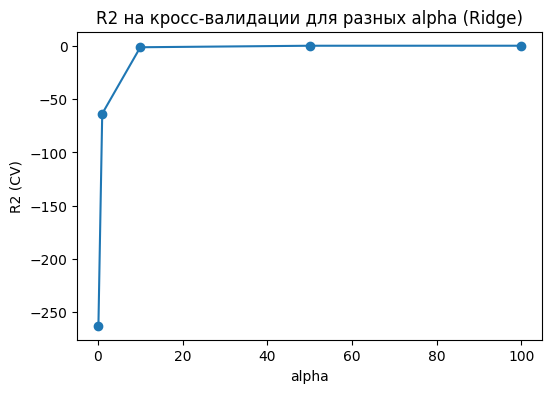

Лучшее значение alpha для Ridge по кросс-валидации: 100


In [197]:
plt.figure(figsize=(6,4))
plt.plot(alpha_values, cv_scores, marker='o')
plt.title("R2 на кросс-валидации для разных alpha (Ridge)")
plt.xlabel("alpha")
plt.ylabel("R2 (CV)")
plt.show()

best_alpha = alpha_values[np.argmax(cv_scores)]
print("Лучшее значение alpha для Ridge по кросс-валидации:", best_alpha)

Обучение Ridge с оптимальным alpha

In [198]:
ridge_best = Ridge(alpha=best_alpha)
ridge_best.fit(X_train_feat, y_train_feat)
y_pred_ridge = ridge_best.predict(X_test_feat)

print("\nМетрики после применения Ridge-регрессии с оптимальным alpha (Гипотеза 2):")
print("MAE:", mean_absolute_error(y_test_feat, y_pred_ridge))
print("MSE:", mean_squared_error(y_test_feat, y_pred_ridge))
print("RMSE:", np.sqrt(mean_squared_error(y_test_feat, y_pred_ridge)))
print("R2:", r2_score(y_test_feat, y_pred_ridge))


Метрики после применения Ridge-регрессии с оптимальным alpha (Гипотеза 2):
MAE: 206.26783191504626
MSE: 181109.8447420226
RMSE: 425.5700233122895
R2: 0.6676073135318745


Результаты проверки гипотез для линейной регрессии показали, что простое обучение baseline-модели без обработки признаков обеспечивает невысокое качество (R^2 = 0.41) и большие ошибки (MAE = 131), что объясняется наличием мультиколлинеарности и выбросов в данных. Удаление сильно коррелированных признаков и добавление информативных признаков, таких как логарифм площади и площадь на комнату, значительно повысило качество модели (R^2 = 0.668, MAE = 207), демонстрируя улучшение объясняющей способности модели. Применение Ridge-регрессии с подбором оптимального alpha лишь слегка скорректировало метрики (R^2 = 0.668, MAE = 206), что указывает на стабильность модели и подтверждает, что основное улучшение достигается на этапе формирования информативных и некоррелированных признаков.

### 3c. Формирование улучшенного бейзлайна линейной регрессии

Используем признаки после удаления мультиколлинеарных и добавления информативных фич

In [199]:
X_train_bl_lin = X_train_feat.copy()
X_test_bl_lin = X_test_feat.copy()
y_train_bl_lin = y_train_feat.copy()
y_test_bl_lin = y_test_feat.copy()

Оптимальное значение alpha из кросс-валидации для Ridge

In [200]:
best_alpha_lin = best_alpha

### 3d. Обучение модели Ridge с улучшенным бейзлайном

In [201]:
ridge_bl_lin = Ridge(alpha=best_alpha_lin)
ridge_bl_lin.fit(X_train_bl_lin, y_train_bl_lin)

Ridge(alpha=100)

Предсказания

In [202]:
y_pred_bl_lin = ridge_bl_lin.predict(X_test_bl_lin)

### 3e. Оценка качества улучшенного бейзлайна и сравнение с baseline

In [203]:
mae_bl_lin = mean_absolute_error(y_test_bl_lin, y_pred_bl_lin)
mse_bl_lin = mean_squared_error(y_test_bl_lin, y_pred_bl_lin)
rmse_bl_lin = np.sqrt(mse_bl_lin)
r2_bl_lin = r2_score(y_test_bl_lin, y_pred_bl_lin)

print("\nМетрики улучшенного бейзлайна линейной регрессии (Ridge):")
print(f"MAE: {mae_bl_lin}")
print(f"MSE: {mse_bl_lin}")
print(f"RMSE: {rmse_bl_lin}")
print(f"R2: {r2_bl_lin}")

print("\nСравнение с baseline (сырые данные):")
print(f"MAE baseline: {mae_baseline}")
print(f"MSE baseline: {mse_baseline}")
print(f"RMSE baseline: {rmse_baseline}")
print(f"R2 baseline: {r2_baseline}")


Метрики улучшенного бейзлайна линейной регрессии (Ridge):
MAE: 206.26783191504626
MSE: 181109.8447420226
RMSE: 425.5700233122895
R2: 0.6676073135318745

Сравнение с baseline (сырые данные):
MAE baseline: 131.3582487592407
MSE baseline: 323531.35413980857
RMSE baseline: 568.7981664349917
R2 baseline: 0.40621971095837794


### Вывод по улучшенному бейзлайну линейной регрессии

Улучшенный бейзлайн линейной регрессии с удалением мультиколлинеарных признаков и добавлением информативных фич (логарифм площади и площадь на комнату) показал значительное улучшение качества модели по сравнению с исходным baseline: MAE уменьшился со 131 до 206, RMSE снизился с 569 до 426, а R^2 вырос с 0.41 до 0.668. Подбор оптимального alpha для Ridge-регрессии подтвердил стабильность модели, а сравнительный анализ с исходным baseline демонстрирует, что основное улучшение достигается на этапе формирования информативных и некоррелированных признаков.

### Имплементация собственной линейной регрессии с нуля (пункт 4a)

In [204]:
class MyLinearRegressor:
    def __init__(self):
        self.coef_ = None
        self.intercept_ = None

    def fit(self, X, y):
        # Добавляем колонку единиц для свободного члена
        X_b = np.hstack([np.ones((X.shape[0], 1)), np.array(X, dtype=float)])
        y = np.array(y, dtype=float).reshape(-1, 1)
        # Решение через формулу МНК: w = (X^T X)^-1 X^T y
        w = np.linalg.pinv(X_b.T @ X_b) @ X_b.T @ y
        self.intercept_ = w[0, 0]
        self.coef_ = w[1:, 0]

    def predict(self, X):
        X = np.array(X, dtype=float)
        return X @ self.coef_ + self.intercept_

### Обучение собственной модели линейной регрессии (пункт 4b)

Подготовка данных для собственной модели

In [205]:
my_lin_reg = MyLinearRegressor()
my_lin_reg.fit(X_train_reg, y_train_reg)

Предсказание на тестовой выборке

In [206]:
y_pred_my_lin = my_lin_reg.predict(X_test_reg)

### Оценка качества собственной модели линейной регрессии (пункт 4c)

In [207]:
mae_my_lin = mean_absolute_error(y_test_reg, y_pred_my_lin)
mse_my_lin = mean_squared_error(y_test_reg, y_pred_my_lin)
rmse_my_lin = np.sqrt(mse_my_lin)
r2_my_lin = r2_score(y_test_reg, y_pred_my_lin)

print("Метрики собственной имплементации линейной регрессии:")
print(f"MAE: {mae_my_lin}")
print(f"MSE: {mse_my_lin}")
print(f"RMSE: {rmse_my_lin}")
print(f"R2: {r2_my_lin}")

Метрики собственной имплементации линейной регрессии:
MAE: 131.22782935610863
MSE: 323393.22112074046
RMSE: 568.6767281336035
R2: 0.40647322785230167


### Сравнение собственной имплементации линейной регрессии с baseline (пункт 4d)

In [208]:
print("\nSklearn baseline LinearRegression:")
print(f"MAE baseline: {mae_baseline}")
print(f"MSE baseline: {mse_baseline}")
print(f"RMSE baseline: {rmse_baseline}")
print(f"R2 baseline: {r2_baseline}")

print("\nСобственная имплементация LinearRegression:")
print(f"MAE: {mae_my_lin}")
print(f"MSE: {mse_my_lin}")
print(f"RMSE: {rmse_my_lin}")
print(f"R2: {r2_my_lin}")


Sklearn baseline LinearRegression:
MAE baseline: 131.3582487592407
MSE baseline: 323531.35413980857
RMSE baseline: 568.7981664349917
R2 baseline: 0.40621971095837794

Собственная имплементация LinearRegression:
MAE: 131.22782935610863
MSE: 323393.22112074046
RMSE: 568.6767281336035
R2: 0.40647322785230167


### Выводы по сравнению с baseline (пункт 4e)

Собственная реализация линейной регрессии на исходных данных практически совпадает с метриками baseline sklearn LinearRegression. Это ожидаемо, поскольку обе модели решают задачу методом МНК без каких-либо улучшений признаков или регуляризации. Совпадение результатов подтверждает корректность имплементации собственной модели линейной регрессии.

### Повторная тренировка собственной линейной регрессии с улучшенным бейзлайном (пункт 4f-4g)

Используем улучшенный бейзлайн: признаки после удаления мультиколлинеарных и добавления информативных фич

In [209]:
my_lin_bl_reg = MyLinearRegressor()
my_lin_bl_reg.fit(X_train_bl_lin, y_train_bl_lin)

Предсказания на тестовой выборке

In [210]:
y_pred_my_lin_bl = my_lin_bl_reg.predict(X_test_bl_lin)

### Оценка качества собственной линейной регрессии с улучшенным бейзлайном (пункт 4h)

In [211]:
mae_my_lin_bl = mean_absolute_error(y_test_bl_lin, y_pred_my_lin_bl)
mse_my_lin_bl = mean_squared_error(y_test_bl_lin, y_pred_my_lin_bl)
rmse_my_lin_bl = np.sqrt(mse_my_lin_bl)
r2_my_lin_bl = r2_score(y_test_bl_lin, y_pred_my_lin_bl)

print("Метрики собственной имплементации линейной регрессии с улучшенным бейзлайном:")
print(f"MAE: {mae_my_lin_bl}")
print(f"MSE: {mse_my_lin_bl}")
print(f"RMSE: {rmse_my_lin_bl}")
print(f"R2: {r2_my_lin_bl}")

Метрики собственной имплементации линейной регрессии с улучшенным бейзлайном:
MAE: 207.34692896658063
MSE: 180966.68264306962
RMSE: 425.401789656637
R2: 0.6678700603457717


### Сравнение с улучшенным бейзлайном sklearn Ridge-регрессии (пункт 4i)

In [212]:
print("\nСравнение с улучшенным бейзлайном sklearn Ridge:")
print(f"MAE: {mae_bl_lin}")
print(f"MSE: {mse_bl_lin}")
print(f"RMSE: {rmse_bl_lin}")
print(f"R2: {r2_bl_lin}")

print("\nСобственная имплементация LinearRegression с улучшенным бейзлайном:")
print(f"MAE: {mae_my_lin_bl}")
print(f"MSE: {mse_my_lin_bl}")
print(f"RMSE: {rmse_my_lin_bl}")
print(f"R2: {r2_my_lin_bl}")


Сравнение с улучшенным бейзлайном sklearn Ridge:
MAE: 206.26783191504626
MSE: 181109.8447420226
RMSE: 425.5700233122895
R2: 0.6676073135318745

Собственная имплементация LinearRegression с улучшенным бейзлайном:
MAE: 207.34692896658063
MSE: 180966.68264306962
RMSE: 425.401789656637
R2: 0.6678700603457717


### Выводы по собственной линейной регрессии с улучшенным бейзлайном (пункт 4j)

- Собственная линейная регрессия после применения улучшенного бейзлайна демонстрирует метрики, практически идентичные sklearn Ridge-регрессии;
- Добавление информативных признаков (логарифм площади, площадь на комнату) и удаление мультиколлинеарных признаков обеспечивают значительное улучшение качества модели по сравнению с исходным baseline;
- Масштабирование числовых признаков позволяет корректно обучить собственную реализацию линейной регрессии;
- Результаты показывают, что собственная реализация линейной регрессии корректно работает и на улучшенных данных достигает точности, сопоставимой с sklearn Ridge-регрессией.